# ＊PYTORCHによるBERTの実装


- 環境:Ubuntu18.04
- GPU:Quadro RTX 8000
- ドライバー:NVIDIA-SMI 460.32.03, Driver Version: 460.32.03, CUDA Version: 11.2
- 事前学習済みモデル:https://nlp.ist.i.kyoto-u.ac.jp/?ku_bert_japanese
    - ./weights:pytorch_model.bin, config.json
    - ./vocab:vocab.txt
    - ./data:train.tsv, test.tsv, train_dumy.tsv, test_dumy.tsv(ダミーデータが必要)
    - ./:test.csv
- 形態素解析時にストップワードを利用する場合はbert.pyの25行目と731行目のコメントアウトを外すこと
- EarlyStoppingを利用する場合はhttps://github.com/Bjarten/early-stopping-pytorch からpytorchtools.pyをutilsにインストールし学習・検証のコメントアウトを外すこと
    

# ＊事前準備


In [ ]:
!conda create -n pytorch_bert python=3.7
!conda activate pytorch_bert
!conda install pytorch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0 cudatoolkit=11.1 -c pytorch -c conda-forge
!conda install jupyter
!pip install transformers==2.9.0
!pip install torchtext
!pip install tqdm
!pip install pyknp
!pip install attrdict
!pip install spacy
!pip install mojimoji

# ＊Juman前処理

In [1]:
import random
import time
import numpy as np
from tqdm import tqdm
import torch 
from torch import nn
import torch.optim as optim
import torchtext

In [2]:
from utils.dataloader import DataLoaders_and_TEXT_train_val, DataLoaders_and_TEXT_batch_train_val
from utils.bert import BertTokenizer

max_length=128
path_result="./result/心配/5/"
path_weights="./weights/心配/5/"

In [3]:
#形態素解析
train_val_ds, test_ds, TEXT= DataLoaders_and_TEXT_train_val(max_length)

In [4]:
batch_size=32
test_dl, TEXT, dataloaders_dict, dataloaders_dict_val, test_ds= DataLoaders_and_TEXT_batch_train_val(train_val_ds, test_ds, TEXT, batch_size)

In [5]:
# 動作確認 テストデータのデータセットで確認
batch = next(iter(test_dl))
print(batch)
print(batch.Text)
print(batch.Label)


[torchtext.legacy.data.batch.Batch of size 32]
	[.Text]:('[torch.LongTensor of size 32x128]', '[torch.LongTensor of size 32]')
	[.Label]:[torch.LongTensor of size 32]
(tensor([[    2,  1338, 18400,  ...,     0,     0,     0],
        [    2,  8428,  2665,  ...,     0,     0,     0],
        [    2,     1,    13,  ...,     0,     0,     0],
        ...,
        [    2,  6309,  1412,  ...,     0,     0,     0],
        [    2,  6309,     6,  ...,     0,     0,     0],
        [    2,  2926,  6309,  ...,     0,     0,     0]]), tensor([ 75,  71,  75,  59,  66,  57,  76, 107,  68,  77,  75, 102,  64,  73,
         85,  52,  50,  40,  70,  36,  75,  65,  73,  65,  32, 103,  41,  61,
         64,  88,  69,  60]))
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [6]:
from utils.bert import BertTokenizer
from utils.config import PKL_FILE, VOCAB_FILE, DATA_PATH
tokenizer_bert = BertTokenizer(vocab_file=VOCAB_FILE, do_lower_case=False)

# ミニバッチの1文目を確認してみる
text_minibatch_1 = (batch.Text[0][1]).numpy()

# IDを単語に戻す
text = tokenizer_bert.convert_ids_to_tokens(text_minibatch_1)

print(text)

['[CLS]', '【', '注意', '喚起', '】', '停電', '発生', '時', 'は', '[UNK]', '再開', '後', '、', '火災', 'が', '発生', 'する', '危険', '性', 'が', '高まり', 'ます', '●', '停電', '中', 'の', '自宅', 'を', '離れる', '時', 'は', '[UNK]', 'を', '落とし', '、', '●', '[UNK]', '再開', '後', 'は', '機器', '等', 'の', '損傷', 'が', 'ない', 'か', '・', '燃え', 'やすい', 'もの', 'が', '近く', 'に', '[UNK]', '等', 'を', '確認', 'して', 'から', '[UNK]', 'を', '戻して', 'ください', '＃', '台風', '第', '[UNK]', '号', '…', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


# ＊BERTモデルを構築

In [6]:
from utils.bert import get_config, BertModel, set_learned_params

# モデル設定のJOSNファイルをオブジェクト変数として読み込みます
config = get_config(file_path="./weights/config.json")

# BERTモデルを作成します
net_bert = BertModel(config)

# BERTモデルに学習済みパラメータセットします
net_bert = set_learned_params(
    net_bert, weights_path="./weights/pytorch_model.bin")


bert.embeddings.word_embeddings.weight→embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight→embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight→embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight→embeddings.LayerNorm.gamma
bert.embeddings.LayerNorm.bias→embeddings.LayerNorm.beta
bert.encoder.layer.0.attention.self.query.weight→encoder.layer.0.attention.selfattn.query.weight
bert.encoder.layer.0.attention.self.query.bias→encoder.layer.0.attention.selfattn.query.bias
bert.encoder.layer.0.attention.self.key.weight→encoder.layer.0.attention.selfattn.key.weight
bert.encoder.layer.0.attention.self.key.bias→encoder.layer.0.attention.selfattn.key.bias
bert.encoder.layer.0.attention.self.value.weight→encoder.layer.0.attention.selfattn.value.weight
bert.encoder.layer.0.attention.self.value.bias→encoder.layer.0.attention.selfattn.value.bias
bert.encoder.layer.0.attention.output.dense.weight→encoder.layer.0.attention.outpu

In [7]:
class BertClassifier(nn.Module):

    def __init__(self, net_bert):
        super(BertClassifier, self).__init__()

        # BERTモジュール
        self.bert = net_bert  # BERTモデル

        # headに予測を追加
        # 入力はBERTの出力特徴量の次元、出力は2つ
        self.cls = nn.Linear(in_features=768, out_features=2)
        #増やす場合はout_reaturesを変更する
        #self.cls = nn.Linear(in_features=768, out_features=3)

        # 重み初期化処理
        nn.init.normal_(self.cls.weight, std=0.02)
        nn.init.normal_(self.cls.bias, 0)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, output_all_encoded_layers=False, attention_show_flg=False):
        '''
        input_ids： [batch_size, sequence_length]の文章の単語IDの羅列
        token_type_ids： [batch_size, sequence_length]の、各単語が1文目なのか、2文目なのかを示すid
        attention_mask：Transformerのマスクと同じ働きのマスキングです
        output_all_encoded_layers：最終出力に12段のTransformerの全部をリストで返すか、最後だけかを指定
        attention_show_flg：Self-Attentionの重みを返すかのフラグ
        '''

        # BERTの基本モデル部分の順伝搬
        # 順伝搬させる
        if attention_show_flg == True:
            '''attention_showのときは、attention_probsもリターンする'''
            encoded_layers, pooled_output, attention_probs = self.bert(
                input_ids, token_type_ids, attention_mask, output_all_encoded_layers, attention_show_flg)
        elif attention_show_flg == False:
            encoded_layers, pooled_output = self.bert(
                input_ids, token_type_ids, attention_mask, output_all_encoded_layers, attention_show_flg)

        # 入力文章の1単語目[CLS]の特徴量を使用して、分類します
        vec_0 = encoded_layers[:, 0, :]
        vec_0 = vec_0.view(-1, 768)  # sizeを[batch_size, hidden_sizeに変換
        out = self.cls(vec_0)

        # attention_showのときは、attention_probs（1番最後の）もリターンする
        if attention_show_flg == True:
            return out, attention_probs
        elif attention_show_flg == False:
            return out


In [8]:
# モデル構築
net = BertClassifier(net_bert)

# 訓練モードに設定
net.train()

print('ネットワーク設定完了')


ネットワーク設定完了


# ＊BERTのファインチューニング

In [9]:
# 勾配計算を最後のBertLayerモジュールと追加した分類アダプターのみ実行

# 1. まず全部を、勾配計算Falseにしてしまう
for name, param in net.named_parameters():
    param.requires_grad = False

# 2. 最後のBertLayerモジュールを勾配計算ありに変更
for name, param in net.bert.encoder.layer[-1].named_parameters():
    param.requires_grad = True

# 3. 識別器を勾配計算ありに変更
for name, param in net.cls.named_parameters():
    param.requires_grad = True


In [10]:
# 最適化手法の設定

# BERTの元の部分はファインチューニング
optimizer = optim.Adam([
    {'params': net.bert.encoder.layer[-1].parameters(), 'lr': 5e-5},
    {'params': net.cls.parameters(), 'lr': 1e-3}
], betas=(0.9, 0.999))

# 損失関数の設定
criterion = nn.CrossEntropyLoss()
# nn.LogSoftmax()を計算してからnn.NLLLoss(negative log likelihood loss)を計算


# ＊学習・検証

## ＊ 開発データでハイパーパラメータを決定

In [ ]:
# モデルを学習させる関数を作成
#from utils.pytorchtools import EarlyStopping
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #エポック数,Acuraccy,Loss保存用
    Epochs=[]
    Accuracy_train=[]
    Loss_train=[]
    Accuracy_val=[]
    Loss_val=[]
    
    #イテレータのエポック数,Acuraccy,Loss保存用
    Epochs_it=[]
    Accuracy_train_it=[]
    Loss_train_it=[]
    
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    print("使用デバイス：", device)
    print('-----start-------')
    #early_stopping = EarlyStopping(patience=10)
    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # ミニバッチのサイズ
    batch_size = dataloaders_dict["train"].batch_size
    n=0
    #時間
    start =time.time()
    # epochのループ
    for epoch in range(num_epochs):
        """
        if early_stopping.early_stop:
            print("Early Stopping")
            break # 打ち切り
        # epochごとの訓練と検証のループ
        """
        
        for phase in ['train', 'val']:
            count=0
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに
                count=1
            
            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数
            iteration = 1

            # 開始時刻を保存
            t_epoch_start = time.time()
            t_iter_start = time.time()

            # データローダーからミニバッチを取り出すループ
            for batch in (dataloaders_dict[phase]):
                # batchはTextとLableの辞書型変数

                # GPUが使えるならGPUにデータを送る
                inputs = batch.Text[0].to(device)  # 文章
                labels = batch.Label.to(device)  # ラベル

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):

                    # BertForIMDbに入力
                    outputs = net(inputs, token_type_ids=None, attention_mask=None,
                                  output_all_encoded_layers=False, attention_show_flg=False)

                    loss = criterion(outputs, labels)  # 損失を計算

                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        
                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            acc = (torch.sum(preds == labels.data)).double()/batch_size
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec. || 本イテレーションの正解率：{}'.format(iteration, loss.item(), duration, acc))
                            t_iter_start = time.time()
                            
                            """
                            Epochs_it.append(iteration/10)
                            Accuracy_train_it.append(acc)
                            Loss_train_it.append(loss.item())
                            """
                            #early_stopping(loss.item(), net)
                                       

                    iteration += 1

                    # 損失と正解数の合計を更新
                    epoch_loss += loss.item() * batch_size
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            # epochごとのlossと正解率
            t_epoch_finish = time.time()
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, num_epochs,
                                                                           phase, epoch_loss, epoch_acc))
            
            a=float("{:.4f}".format(epoch_acc))
                
            t_epoch_start = time.time()
            
            if count == 0:
                Loss_train.append(epoch_loss)
                Accuracy_train.append(a)
            elif count==1:
                Loss_val.append(epoch_loss)
                Accuracy_val.append(a)
        Epochs.append(epoch+1)
    t=time.time()
    print("Time:{:.4f}sec".format(t-start))
        
    return net,Epochs,Loss_train,Accuracy_train,Loss_val,Accuracy_val


In [ ]:
# 学習・検証を実行する。1epochに20分ほどかかります
num_epochs = 30
net_trained, Epochs, Loss_train, Accuracy_train, Loss_val, Accuracy_val = train_model(net, dataloaders_dict_val,
                          criterion, optimizer, num_epochs=num_epochs)


## ＊学習時のEpochsごとのAccuracyを出力

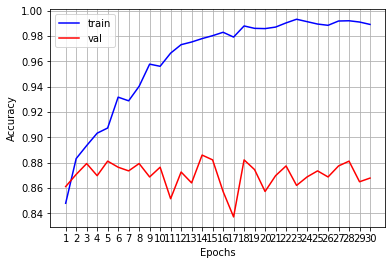

In [14]:
import matplotlib.pyplot as plt
#print(Accuracy_train)
#print(Accuracy_val)
#Accuracy_test=[]
plt.plot(Epochs,Accuracy_train,color="blue",label="train")
plt.plot(Epochs,Accuracy_val,color="red",label="val")
#plt.plot(Epochs,Accuracy_test,color="red",label="test")
plt.xticks(Epochs)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.savefig(path_result+"acc_val.png")

## ＊学習時のEpochsごとのLossを出力

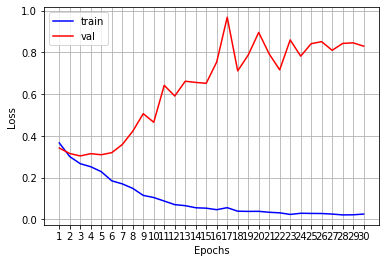

In [15]:
#plt.axes().set_aspect("equal")
#Loss_test=[]
plt.plot(Epochs, Loss_train,color="blue",label="train")
plt.plot(Epochs, Loss_val,color="red",label="val")
#plt.plot(Epochs,Loss_test,color="red",label="test")
plt.xticks(Epochs)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.savefig(path_result+"Loss_val.png")

## ＊ 全データで学習

In [11]:
# モデルを学習させる関数を作成
#from utils.pytorchtools import EarlyStopping
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #エポック数,Acuraccy,Loss保存用
    Epochs=[]
    Accuracy_train=[]
    Loss_train=[]
    Accuracy_val=[]
    Loss_val=[]
    
    #イテレータのエポック数,Acuraccy,Loss保存用
    Epochs_it=[]
    Accuracy_train_it=[]
    Loss_train_it=[]
    
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    print("使用デバイス：", device)
    print('-----start-------')
    #early_stopping = EarlyStopping(patience=10)
    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # ミニバッチのサイズ
    batch_size = dataloaders_dict["train"].batch_size
    n=0
    #時間
    start =time.time()
    # epochのループ
    for epoch in range(num_epochs):
        """
        if early_stopping.early_stop:
            print("Early Stopping")
            break # 打ち切り
        # epochごとの訓練と検証のループ
        """
        
        #for phase in ['train', 'val']:
        for phase in ['train']:
            count=0
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに
                count=1
            
            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数
            iteration = 1

            # 開始時刻を保存
            t_epoch_start = time.time()
            t_iter_start = time.time()

            # データローダーからミニバッチを取り出すループ
            for batch in (dataloaders_dict[phase]):
                # batchはTextとLableの辞書型変数

                # GPUが使えるならGPUにデータを送る
                inputs = batch.Text[0].to(device)  # 文章
                labels = batch.Label.to(device)  # ラベル

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):

                    # BertForIMDbに入力
                    outputs = net(inputs, token_type_ids=None, attention_mask=None,
                                  output_all_encoded_layers=False, attention_show_flg=False)

                    loss = criterion(outputs, labels)  # 損失を計算

                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        
                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            acc = (torch.sum(preds == labels.data)).double()/batch_size
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec. || 本イテレーションの正解率：{}'.format(iteration, loss.item(), duration, acc))
                            t_iter_start = time.time()
                            
                            """
                            Epochs_it.append(iteration/10)
                            Accuracy_train_it.append(acc)
                            Loss_train_it.append(loss.item())
                            """
                            #early_stopping(loss.item(), net)
                                       

                    iteration += 1

                    # 損失と正解数の合計を更新
                    epoch_loss += loss.item() * batch_size
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            # epochごとのlossと正解率
            t_epoch_finish = time.time()
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, num_epochs,
                                                                           phase, epoch_loss, epoch_acc))
            
            a=float("{:.4f}".format(epoch_acc))
                
            t_epoch_start = time.time()
            
            if count == 0:
                Loss_train.append(epoch_loss)
                Accuracy_train.append(a)
            elif count==1:
                Loss_val.append(epoch_loss)
                Accuracy_val.append(a)
        Epochs.append(epoch+1)
    t=time.time()
    print("Time:{:.4f}sec".format(t-start))
        
    return net,Epochs,Loss_train,Accuracy_train,Loss_val,Accuracy_val


In [12]:
# 学習・検証を実行する。
num_epochs = 3
net_trained, Epochs, Loss_train, Accuracy_train, Loss_val, Accuracy_val = train_model(net, dataloaders_dict,
                          criterion, optimizer, num_epochs=num_epochs)

使用デバイス： cuda:0
-----start-------
イテレーション 10 || Loss: 0.4174 || 10iter: 0.9877 sec. || 本イテレーションの正解率：0.8125
イテレーション 20 || Loss: 0.3592 || 10iter: 0.9631 sec. || 本イテレーションの正解率：0.84375
イテレーション 30 || Loss: 0.3391 || 10iter: 0.9627 sec. || 本イテレーションの正解率：0.8125
イテレーション 40 || Loss: 0.3425 || 10iter: 0.9634 sec. || 本イテレーションの正解率：0.90625
イテレーション 50 || Loss: 0.4970 || 10iter: 0.9630 sec. || 本イテレーションの正解率：0.78125
イテレーション 60 || Loss: 0.4121 || 10iter: 0.9644 sec. || 本イテレーションの正解率：0.84375
イテレーション 70 || Loss: 0.4136 || 10iter: 0.9654 sec. || 本イテレーションの正解率：0.8125
イテレーション 80 || Loss: 0.4260 || 10iter: 0.9660 sec. || 本イテレーションの正解率：0.78125
イテレーション 90 || Loss: 0.3878 || 10iter: 0.9653 sec. || 本イテレーションの正解率：0.84375
イテレーション 100 || Loss: 0.3116 || 10iter: 0.9660 sec. || 本イテレーションの正解率：0.8125
イテレーション 110 || Loss: 0.3178 || 10iter: 0.9667 sec. || 本イテレーションの正解率：0.90625
イテレーション 120 || Loss: 0.2970 || 10iter: 0.9678 sec. || 本イテレーションの正解率：0.875
イテレーション 130 || Loss: 0.3524 || 10iter: 0.9682 sec. || 本イテレーションの正解率：0.78125
イテレーション

In [13]:
# 学習したネットワークパラメータを保存します
save_path = path_weights+'bert_fine_tuning.pth'
torch.save(net_trained.state_dict(), save_path)

## ＊＊＊保存しているモデルを使用する場合＊＊＊
- BERTモデルを構築


In [ ]:
from utils.bert import get_config, BertModel, set_learned_params

# モデル設定のJOSNファイルをオブジェクト変数として読み込みます
config = get_config(file_path="./weights/config.json")

# BERTモデルを作成します
net_bert = BertModel(config)

# BERTモデルに学習済みパラメータセットします
net_bert = set_learned_params(
    net_bert, weights_path="./weights/pytorch_model.bin")


In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, net_bert):
        super(BertForIMDb, self).__init__()

        # BERTモジュール
        self.bert = net_bert  # BERTモデル

        # headに予測を追加
        # 入力はBERTの出力特徴量の次元、出力は2つ
        self.cls = nn.Linear(in_features=768, out_features=2)
        #増やす場合はout_reaturesを変更する
        #self.cls = nn.Linear(in_features=768, out_features=3)

        # 重み初期化処理
        nn.init.normal_(self.cls.weight, std=0.02)
        nn.init.normal_(self.cls.bias, 0)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, output_all_encoded_layers=False, attention_show_flg=False):
        '''
        input_ids： [batch_size, sequence_length]の文章の単語IDの羅列
        token_type_ids： [batch_size, sequence_length]の、各単語が1文目なのか、2文目なのかを示すid
        attention_mask：Transformerのマスクと同じ働きのマスキングです
        output_all_encoded_layers：最終出力に12段のTransformerの全部をリストで返すか、最後だけかを指定
        attention_show_flg：Self-Attentionの重みを返すかのフラグ
        '''

        # BERTの基本モデル部分の順伝搬
        # 順伝搬させる
        if attention_show_flg == True:
            '''attention_showのときは、attention_probsもリターンする'''
            encoded_layers, pooled_output, attention_probs = self.bert(
                input_ids, token_type_ids, attention_mask, output_all_encoded_layers, attention_show_flg)
        elif attention_show_flg == False:
            encoded_layers, pooled_output = self.bert(
                input_ids, token_type_ids, attention_mask, output_all_encoded_layers, attention_show_flg)

        # 入力文章の1単語目[CLS]の特徴量を使用して、分類します
        vec_0 = encoded_layers[:, 0, :]
        vec_0 = vec_0.view(-1, 768)  # sizeを[batch_size, hidden_sizeに変換
        out = self.cls(vec_0)

        # attention_showのときは、attention_probs（1番最後の）もリターンする
        if attention_show_flg == True:
            return out, attention_probs
        elif attention_show_flg == False:
            return out


In [ ]:
# モデル構築
net_trained = BertClassifier(net_bert)

# 訓練モードに設定
net_trained.train()

print('ネットワーク設定完了')

#学習済みモデルを読み込む
model_path = './weights/bert_fine_tuning_dokokara_5.pth'
net_trained.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# 損失関数の設定
criterion = nn.CrossEntropyLoss()
# nn.LogSoftmax()を計算してからnn.NLLLoss(negative log likelihood loss)を計算

## ＊＊＊Juman前処理用（テストデータのみ）＊＊＊

In [ ]:
from utils.dataloader import  DataLoaders_and_TEXT_test
max_length=128
batch_size=16
test_dl,TEXT, dataloaders_dict, test_ds=  DataLoaders_and_TEXT_test(max_length, batch_size)

## ＊検証

In [14]:
import pandas as pd
#cc=nn.Softmax(dim=1)
# テストデータでの正解率を求める
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_trained.eval()   # モデルを検証モードに
net_trained.to(device)  # GPUが使えるならGPUへ送る

# epochの正解数を記録する変数
epoch_corrects = 0

predicted_label=[]#予測ラベル
ture_label=[]#正解ラベル

score_0=[]#0のスコア
score_1=[]#1のスコア
count=0

for batch in tqdm(test_dl):  # testデータのDataLoader
    # batchはTextとLableの辞書オブジェクト
    # GPUが使えるならGPUにデータを送る
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    inputs = batch.Text[0].to(device)  # 文章
    labels = batch.Label.to(device)  # ラベル
    epoch_loss=0.0

    
    # 順伝搬（forward）計算
    with torch.set_grad_enabled(False):

        # BertForIMDbに入力
        outputs = net_trained(inputs, token_type_ids=None, attention_mask=None,
                              output_all_encoded_layers=False, attention_show_flg=False)

        loss = criterion(outputs, labels)  # 損失を計算
        
        _, preds = torch.max(outputs, 1)  # ラベルを予測
        epoch_corrects += torch.sum(preds == labels.data)  # 正解数の合計を更新
        
        #outputs=cc(outputs)
        for i in range(batch_size):
            try:
                s1=outputs[i][0].item()
                s2=outputs[i][1].item()
                p_label = preds[i].item()
                t_label = labels[i].item()
                score_0.append(s1)
                score_1.append(s2)
                predicted_label.append(p_label)
                ture_label.append(t_label)
                count+=1
            except:
                break
        epoch_loss += loss.item() * batch_size
        
epoch_loss = epoch_loss / len(test_dl.dataset)
print('Loss:{:.4f}'.format(epoch_loss))
# 正解率
epoch_acc = epoch_corrects.double() / len(test_dl.dataset)

print('テストデータ{}個での正解率：{:.4f}'.format(len(test_dl.dataset), epoch_acc))


#df = pd.read_csv("./data/test.csv", engine="python", encoding="sjis")
#df = pd.read_csv("./data/test.csv", engine="python", encoding="utf-8-sig")
df = pd.read_csv("./data/test.csv", names=("TEXT", "LABEL"), engine="python", encoding="utf-8-sig")
#df["TEXT"] = np.nan   #予測列を追加
#df["LABEL"] = np.nan   #予測列を追加
df["PREDICT"] = np.nan   #予測列を追加
df["AUC+"] = np.nan   #予測列を追加
df["AUC-"] = np.nan   #予測列を追加

for index in range(count):
    df.at[index, "PREDICT"] = predicted_label[index]
    
    df.at[index, "AUC+"] = score_0[index]
    df.at[index, "AUC-"] = score_1[index]
    
    
df.to_csv(path_result+"predicted_test.csv", encoding="utf-8-sig", index=False)

#df.to_csv("./result/predicted_test_10.csv", encoding="sjis",index=False)


100%|██████████| 41/41 [00:03<00:00, 10.80it/s]

Loss:0.0119
テストデータ1304個での正解率：0.8620


## ＊検証時のROC(AUC)の出力

AUC:0.938571502502917


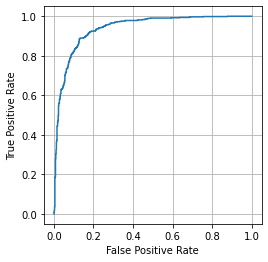

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(ture_label, score_1)
plt.axes().set_aspect("equal")
#plt.plot(fpr, tpr,marker=".")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.savefig(path_result+"roc_curve.png")
auc=roc_auc_score(ture_label,score_1)
print("AUC:{}".format(auc))
with open("{}auc_f.txt".format(path_result),"a",encoding="utf-8") as f:
    f.write("roc_curve, AUC:{}\n".format(auc))
    f.close()

AUC:0.923867334696743


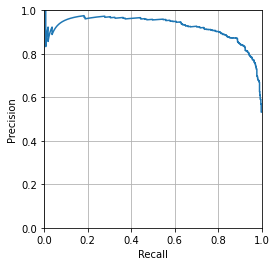

In [16]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
precision, recall, thresholds = precision_recall_curve(ture_label, score_1)
#plt.plot(fpr, tpr,marker=".")
plt.axes().set_aspect("equal")
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.savefig(path_result+"precision_recall.png")
pr_auc=auc(recall, precision)
print("AUC:{}".format(pr_auc))
with open("{}auc_f.txt".format(path_result),"a",encoding="utf-8") as f:
    f.write("precision_recall, AUC:{}\n".format(pr_auc))
    f.close()

## ＊混同行列と精度

In [17]:
from utils.config import *
from IPython.display import HTML, display
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [18]:
#混合行列の表示（評価）
y_true =[]
y_pred =[]
df = pd.read_csv(path_result+"predicted_test.csv", engine="python", encoding="utf-8-sig")
#df = pd.read_csv("./result/predicted_test.csv", engine="python", encoding="sjis")
for index, row in df.iterrows():
    if row['LABEL'] == 0:
        y_true.append("負例")
    if row['LABEL'] ==1:
        y_true.append("正例")
    if row['PREDICT'] ==0:
        y_pred.append("負例")
    if row['PREDICT'] ==1:
        y_pred.append("正例")

    
print(len(y_true))
print(len(y_pred))


# 混同行列(confusion matrix)の取得
labels = ["負例", "正例"]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# データフレームに変換
cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)

# 結果の表示
cm_labeled.to_csv(path_result+"confusion_matrix.csv", encoding="utf-8-sig")
cm_labeled


1304
1304


,負例,正例
負例,513,139
正例,41,611


In [19]:
y_true =[]
y_pred =[]
df = pd.read_csv(path_result+"predicted_test.csv", engine="python", encoding="utf-8-sig")
#df = pd.read_csv("./result/predicted_test.csv", engine="python", encoding="sjis")
for index, row in df.iterrows():
    y_true.append(row["LABEL"])
    y_pred.append(row["PREDICT"])
"""       
print("正解率（すべてのサンプルのうち正解したサンプルの割合）={}%".format((round(accuracy_score(y_true, y_pred),2)) *100 ))
print("適合率（positiveと予測された中で実際にpositiveだった確率）={}%".format((round(precision_score(y_true, y_pred),2)) *100 ))
print("再現率（positiveなデータに対してpositiveと予測された確率）={}%".format((round(recall_score(y_true, y_pred),2)) *100 ))
print("F1（適合率と再現率の調和平均）={}%".format((round(f1_score(y_true, y_pred),2)) *100 ))
"""
print("正解率（すべてのサンプルのうち正解したサンプルの割合）={}".format((accuracy_score(y_true, y_pred))))
print("適合率（positiveと予測された中で実際にpositiveだった確率）={}".format((precision_score(y_true, y_pred))))
print("再現率（positiveなデータに対してpositiveと予測された確率）={}".format((recall_score(y_true, y_pred))))
print("F1（適合率と再現率の調和平均）={}".format((f1_score(y_true, y_pred))))
with open("{}auc_f.txt".format(path_result),"a",encoding="utf-8") as f:
    f.write("正解率（すべてのサンプルのうち正解したサンプルの割合）={}\n".format((accuracy_score(y_true, y_pred))))
    f.write("適合率（positiveと予測された中で実際にpositiveだった確率）={}\n".format((precision_score(y_true, y_pred))))
    f.write("再現率（positiveなデータに対してpositiveと予測された確率）={}\n".format((recall_score(y_true, y_pred))))
    f.write("F1（適合率と再現率の調和平均）={}\n".format((f1_score(y_true, y_pred))))
    f.close()

正解率（すべてのサンプルのうち正解したサンプルの割合）=0.8619631901840491
適合率（positiveと予測された中で実際にpositiveだった確率）=0.8146666666666667
再現率（positiveなデータに対してpositiveと予測された確率）=0.9371165644171779
F1（適合率と再現率の調和平均）=0.8716119828815978


# ＊Attentionの可視化

In [20]:
# BertForIMDbで処理

# ミニバッチの用意
batch = next(iter(test_dl))

# GPUが使えるならGPUにデータを送る
inputs = batch.Text[0].to(device)  # 文章
labels = batch.Label.to(device)  # ラベル

outputs, attention_probs = net_trained(inputs, token_type_ids=None, attention_mask=None,
                                       output_all_encoded_layers=False, attention_show_flg=True)

_, preds = torch.max(outputs, 1)  # ラベルを予測


In [21]:
# HTMLを作成する関数を実装

from utils.bert import BertTokenizer
from utils.config import PKL_FILE, VOCAB_FILE, DATA_PATH
tokenizer_bert = BertTokenizer(vocab_file=VOCAB_FILE, do_lower_case=False)
from utils.tokenizer import JumanTokenize

def highlight(word, attn):
    "Attentionの値が大きいと文字の背景が濃い赤になるhtmlを出力させる関数"

    html_color = '#%02X%02X%02X' % (
        255, int(255*(1 - attn)), int(255*(1 - attn)))
    return '<span style="background-color: {}"> {}</span>'.format(html_color, word)


def mk_html(index, batch, preds, normlized_weights, TEXT):
    "HTMLデータを作成する"

    # indexの結果を抽出
    sentence = batch.Text[0][index]  # 文章
    label = batch.Label[index]  # ラベル
    pred = preds[index]  # 予測

    # ラベルと予測結果を文字に置き換え
    """
    if label == 0:
        label_str = "負例"
    else:
        label_str = "正例"

    if pred == 0:
        pred_str = "負例"
    else:
        pred_str = "正例"
    """
    if label == 0:
        label_str = "非有益"
    else:
        label_str = "有益"

    if pred == 0:
        pred_str = "非有益"
    else:
        pred_str = "有益"


    # 表示用のHTMLを作成する
    #html = '正解ラベル：{}<br>推論ラベル：{}<br><br>'.format(label_str, pred_str)
    html = '正解ラベル：{}<br>推論ラベル：{}<br>'.format(label_str, pred_str)

    # Self-Attentionの重みを可視化。Multi-Headが12個なので、12種類のアテンションが存在
    for i in range(12):

        # indexのAttentionを抽出と規格化
        # 0単語目[CLS]の、i番目のMulti-Head Attentionを取り出す
        # indexはミニバッチの何個目のデータかをしめす
        attens = normlized_weights[index, i, 0, :]
        attens /= attens.max()
        """
        html += '[BERTのAttentionを可視化_' + str(i+1) + ']<br>'
        for word, attn in zip(sentence, attens):

            # 単語が[SEP]の場合は文章が終わりなのでbreak
            if tokenizer_bert.convert_ids_to_tokens([word.numpy().tolist()])[0] == "[SEP]":
                break

            # 関数highlightで色をつける、関数tokenizer_bert.convert_ids_to_tokensでIDを単語に戻す
            html += highlight(tokenizer_bert.convert_ids_to_tokens(
                [word.numpy().tolist()])[0], attn)
        html += "<br><br>"
        """

    # 12種類のAttentionの平均を求める。最大値で規格化
    all_attens = attens*0  # all_attensという変数を作成する
    for i in range(12):
        attens += normlized_weights[index, i, 0, :]
    attens /= attens.max()

    #html += '[BERTのAttentionを可視化_ALL]<br>'
    for word, attn in zip(sentence, attens):

        # 単語が[SEP]の場合は文章が終わりなのでbreak
        
        if tokenizer_bert.convert_ids_to_tokens([word.numpy().tolist()])[0] == "[SEP]":
            break
        

        # 関数highlightで色をつける、関数tokenizer_bert.convert_ids_to_tokensでIDを単語に戻す
        html += highlight(tokenizer_bert.convert_ids_to_tokens(
            [word.numpy().tolist()])[0], attn)
        
    html += "<br><br>"

    return html


In [22]:
from IPython.display import HTML

index = 5  # 出力させたいデータ
html_output = mk_html(index, batch, preds, attention_probs, TEXT)  # HTML作成
HTML(html_output)  # HTML形式で出力


In [23]:
count=0
for batch in test_dl:
    # ミニバッチの用意
    #batch = next(iter(test_dl))

    # GPUが使えるならGPUにデータを送る
    inputs = batch.Text[0].to(device)  # 文章
    labels = batch.Label.to(device)  # ラベル

    outputs, attention_probs = net_trained(inputs, token_type_ids=None, attention_mask=None,
                                           output_all_encoded_layers=False, attention_show_flg=True)
    _, preds = torch.max(outputs, 1)  # ラベルを予測
    
    for index in range(batch_size):
        try:
            html_output = mk_html(index, batch, preds, attention_probs, TEXT)  # HTML作成
            with open("{}test.html".format(path_result),"a", encoding="cp932") as f:
                f.write(html_output)
            count+=1
        except:
            pass 
#print(count)   
#HTML(html_output)  # HTML形式で出力
        # BertForIMDbで処理